In [19]:
%matplotlib inline  
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
import plotly

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt

In [2]:
# Set up functions
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
measure_rmse([1,2],[1,3])

0.7071067811865476

In [3]:
#train_test_split([1,2,3,4,5],2)
def train_test_split(data, n_train):
    train = data.iloc[:n_train]
    test = data.iloc[n_train:]
    return train,test

In [ ]:
def prophet_predict(series):
    series.head()
    m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(series);
    future = m.make_future_dataframe(periods=1,freq='M')
    forecast = m.predict(future)
    return forecast.iloc[-1]["yhat"]

In [ ]:
def score_model(data, n_train, method, cfg, debug=False):
    result = None
    predictions = None
    # convert config to a key
    key = str(cfg)
    result,predictions = walk_forward_validation(data, n_train, method, cfg)
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result, predictions)

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_train, method, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_train)
    # seed history with training dataset
    #history = [x for x in train]
    history = train
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = prophet_predict(history)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(pd.DataFrame(test.iloc[i]))
    # estimate prediction error
    error = measure_rmse(test["y"], predictions)
    return [error,predictions]

In [ ]:
def find_best_solution(series,name,method="prophet"):    
    data = series

    scores = []
    # data split
    n_training = int(len(data)*0.8) # percentage used for test
    max_length = len(data) - n_training
    print("Training size %s " % n_training)
    print("Test size %s " % max_length)
    cfg_list = [1]
    
    scores = [score_model(data, n_training, method, cfg) for cfg in cfg_list]
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])


    print('done')
    # list top 3 configs
    for cfg, error, predictions in scores[:3]:
        print(cfg, error)

    
    #display
    train,test = train_test_split(data,n_training)
    prediction = pd.DataFrame(list(train["y"])+scores[0][2])
    
    #####
    data.set_index(['ds'],inplace=True)
    #prediction.set_index(['ds'],inplace=True)
    prediction.index = data.index


    ax = pd.DataFrame(data).plot(label="Original") # main data
    prediction.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("%s_%s.png" % (name,method))
    plt.show()
    return [data,prediction]

In [4]:
def evaluate_forecast(series,freq="M"):
    data = series
    n_training = int(len(data)*0.8) # percentage used for test
    max_length = len(data) - n_training
    print("Training size %s " % n_training)
    print("Test size %s " % max_length)
    cfg_list = [1]
    train, test = train_test_split(data, n_training)
    m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(series);
    future = m.make_future_dataframe(periods=len(test),freq=freq)
    forecast = m.predict(future)
    m.plot(forecast)
    print("RMSE: %s" % measure_rmse(forecast.iloc[len(train):len(series)]["yhat"],test["y"]))

## Read in incident data and prep for prophet run

In [5]:
# Read in the CSV
incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv", low_memory=False)
incidents = incidents.dropna()
incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23


In [6]:
# Reset the index to date, and split the date into fields for analysis
# incidents.index = pd.DatetimeIndex(incidents.incidentDate)

# incidents['month'] = incidents.index.month
# incidents['year'] = incidents.index.year
# incidents['dayOfWeek'] = incidents.index.dayofweek
# incidents['dayOfMonth'] = incidents.index.day
# incidents['dayOfYear'] = incidents.index.dayofyear
# incidents['weekOfMonth'] = incidents.dayOfMonth.apply(lambda d: (d-1) // 7 +1)

# dayOfYear = list(incidents.index.dayofyear)
# weekOfYear = [math.ceil(i/7) for i in dayOfYear]
# incidents['weekOfYear'] = weekOfYear

# incidents = incidents.sort_index()

incidents.loc[(incidents['neighborhood'] == "Steven'S Square - Loring Heights"), 'neighborhood'] = 'Stevens Square - Loring Heights'

incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23


In [7]:
counts = incidents.groupby(['incidentDate']).count()
counts

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentTime
incidentDate,,,,,,,,,,
2010/01/01,62,62,62,62,62,62,62,62,62,62
2010/01/02,38,38,38,38,38,38,38,38,38,38
2010/01/03,37,37,37,37,37,37,37,37,37,37
2010/01/04,62,62,62,62,62,62,62,62,62,62
2010/01/05,44,44,44,44,44,44,44,44,44,44
...,...,...,...,...,...,...,...,...,...,...
2020/12/26,32,32,32,32,32,32,32,32,32,32
2020/12/27,31,31,31,31,31,31,31,31,31,31
2020/12/28,46,46,46,46,46,46,46,46,46,46


In [ ]:
series = counts.filter(['caseNumber'], axis=1)
series = series.reset_index()
series.rename(columns={'incidentDate':'ds', 'caseNumber':'y'}, inplace=True)
series.head()

In [ ]:
# Set up the series DF to feed into prophet
series['ds'] = pd.to_datetime(series['ds'])
series[['y']] = series[['y']].astype(float)
series = series[['ds','y']]
series.head()

In [ ]:
# This takes about 40 minutes to run
evaluate_forecast(series, freq='W')

## Starting a prophet run from scratch

In [ ]:
# Grab a smaller set of data to do some testing
series_slim = series[series['ds']>='2019-01-01']
series_slim

In [ ]:
# Set up the model as a Prophet instance and fit the dataframe
model = Prophet()
model.fit(series)

In [ ]:
# Set up the future dates for predictions
future = model.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
model.plot(forecast)

In [ ]:
## Break out the seasonal components
model.plot_components(forecast)

In [ ]:
import plotly.graph_objs as go

In [ ]:
plot_plotly(model, forecast)

In [ ]:
series

## Run the model on a weekly basis

In [8]:
counts_reduced = counts[['caseNumber']]
counts_reduced

,caseNumber
incidentDate,
2010/01/01,62
2010/01/02,38
2010/01/03,37
2010/01/04,62
2010/01/05,44
...,...
2020/12/26,32
2020/12/27,31
2020/12/28,46


In [9]:
counts_transposed = counts_reduced.T
counts_transposed

incidentDate,2010/01/01,2010/01/02,2010/01/03,2010/01/04,2010/01/05,2010/01/06,2010/01/07,2010/01/08,2010/01/09,2010/01/10,...,2020/12/21,2020/12/22,2020/12/23,2020/12/24,2020/12/25,2020/12/26,2020/12/27,2020/12/28,2020/12/29,2020/12/30
caseNumber,62,38,37,62,44,37,48,54,31,33,...,38,51,37,32,31,32,31,46,22,34


In [10]:
counts_grouped = counts_transposed.groupby([[i//7 for i in range(0,4017)]], axis=1).sum().T
# counts_grouped

date_range = pd.period_range(start='2010-01-01', end='2020-12-31', freq='W-SUN')
date_range = date_range.map(str)
# date_range
date_range = date_range.str.split('/').str[0]
date_range = pd.Series(date_range)

counts_grouped = counts_grouped.assign(Weeks=date_range)
# counts_grouped.tail()

counts_grouped.set_index(['Weeks']).head()

,caseNumber
Weeks,
2009-12-28,328
2010-01-04,274
2010-01-11,329
2010-01-18,280
2010-01-25,263


In [11]:
counts_grouped = counts_grouped.reset_index()
counts_grouped.rename(columns={'Weeks':'ds', 'caseNumber':'y'}, inplace=True)
counts_grouped.head()

,index,y,ds
0,0,328,2009-12-28
1,1,274,2010-01-04
2,2,329,2010-01-11
3,3,280,2010-01-18
4,4,263,2010-01-25


In [12]:
# Set up the series DF to feed into prophet
counts_grouped['ds'] = pd.to_datetime(counts_grouped['ds'])
counts_grouped[['y']] = counts_grouped[['y']].astype(float)
counts_grouped = counts_grouped[['ds','y']]
counts_grouped

,ds,y
0,2009-12-28,328.0
1,2010-01-04,274.0
2,2010-01-11,329.0
3,2010-01-18,280.0
4,2010-01-25,263.0
...,...,...
569,2020-11-23,343.0
570,2020-11-30,366.0
571,2020-12-07,318.0
572,2020-12-14,329.0


Training size 459 
Test size 115 
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
RMSE: 43.28734365053287


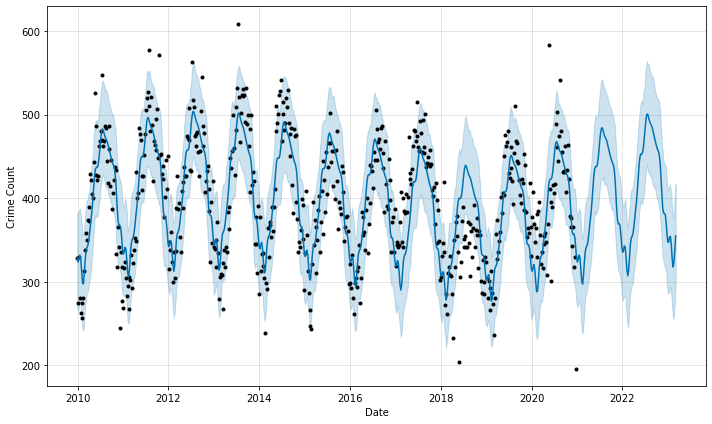

In [26]:
data = counts_grouped
n_training = int(len(data)*0.8) # percentage used for test
max_length = len(data) - n_training
print("Training size %s " % n_training)
print("Test size %s " % max_length)
cfg_list = [1]
train, test = train_test_split(data, n_training)
m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(counts_grouped);
future = m.make_future_dataframe(periods=len(test),freq='W')
forecast = m.predict(future)
m.plot(forecast, xlabel='Date', ylabel='Crime Count')
plt.savefig('images/prophet_weekly_forecast.png')

print("RMSE: %s" % measure_rmse(forecast.iloc[len(train):len(counts_grouped)]["yhat"],test["y"]))

C:\Users\hasse\anaconda3\envs\PythonAdv\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



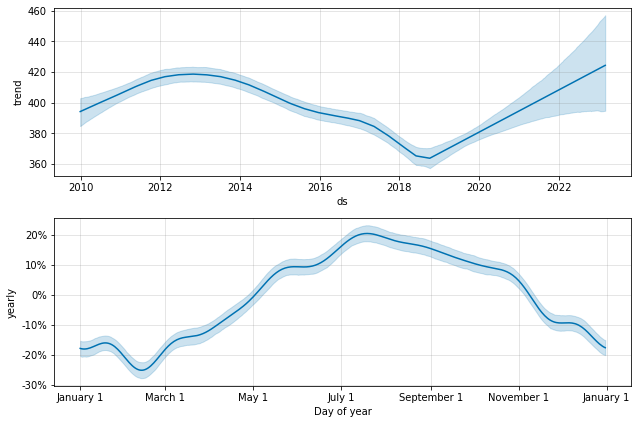

In [28]:
m.plot_components(forecast)
plt.savefig('images/prophet_weekly_trends.png')

In [23]:
plot_plotly(m, forecast, xlabel='Date', ylabel='Crime Count')

In [17]:
plot_components_plotly(m, forecast)

In [25]:
plotly.offline.plot(plot_plotly(m, forecast, xlabel='Date', ylabel='Crime Count'))

'temp-plot.html'

In [29]:
plotly.offline.plot(plot_components_plotly(m, forecast))

'temp-plot.html'